**TRAFFIC SIGN IMAGE CLASSIFICAATION**

**IMAGE CLASSIFICATION USING BAG OF VISUAL WORDS**

**Mariam mariam
MSAI 2k21 
**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
## Install older opencv package for using sift features
!pip install opencv-python==3.4.10.37
!pip install opencv-contrib-python==3.4.10.37

In [3]:
import cv2
import numpy as np
import os
from scipy.cluster.vq import kmeans, vq
from sklearn.preprocessing import StandardScaler
import pylab as pl
from sklearn.metrics import confusion_matrix, accuracy_score
import joblib
#from sklearn.externals import joblib
import matplotlib.pyplot as plt
print(cv2.__version__)

3.4.10


In [4]:
!pip install joblib

In [5]:
#appending path of the dataset folder to mydrive
import sys
import os, zipfile
sys.path.append('/content/drive/MyDrive/Assignment1_CV')

In [6]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Assignment1_CV/dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [40]:
# dataset loading and preprocessing helper class
class BOVW:
  def __init__(self, dataset_path):
    self.dataset_path = dataset_path
    self.train_path = os.path.join(self.dataset_path, "Train")
    self.test_path = os.path.join(self.dataset_path, "Test")

  # Get path to all images and save them in a list
  def get_img_paths_classes(self, mode='Train'):
    if mode=="Train":
      training_names = os.listdir(self.train_path)
      training_names.sort()
      print(training_names)
      folder = self.train_path
    else:
      training_names = os.listdir(self.test_path)
      training_names.sort()
      print(training_names)
      folder = self.test_path
   
    # image_paths and the corresponding label in image_paths
    image_paths = []
    image_classes = []
    class_id = 0
    
    #To make it easy to list all file names in a directory we are defining a function
    
    def imglist(path):    
      return [os.path.join(path, f) for f in os.listdir(path)]
    
    #Fill the placeholder empty lists with image path, classes, and add class ID number
    # Assigning Class_Ids to various folders from 1 to 10 in the training images dataset
    
    for training_name in training_names:
      dir = os.path.join(folder, training_name)
      class_path = imglist(dir)
      image_paths+=class_path
      image_classes+=[class_id]*len(class_path)
      class_id+=1
    return (image_paths, image_classes, class_id, training_names)

  def get_features_descriptors(self, image_paths, image_classes, class_id):
    # Create feature extraction and keypoint detector objects  
    # Create List where all the descriptors will be stored
    des_list = []
    
    orb = cv2.xfeatures2d.SIFT_create()
    for image_path in image_paths:
      im = cv2.imread(image_path)
      kpts, des = orb.detectAndCompute(im, None)
      des_list.append((image_path, des))  


    # Stacking all the descriptors vertically in a numpy array
    descriptors = des_list[0][1]

    for image_path, descriptor in des_list[1:]:
      descriptors = np.vstack((descriptors, descriptor))  


    #kmeans works only on float, so convert integers to float
    descriptors_float = descriptors.astype(float)  
    return descriptors_float, des_list

  def get_final_features(self, descriptors_float, des_list, image_paths):
    # Perform k-means clustering and vector quantization

    k = 150  
    voc, variance = kmeans(descriptors_float, k, 1) 

   
    #vector quantization  Assigns codes from a code book to observations.
    im_features = np.zeros((len(image_paths), k), "float32")
    for i in range(len(image_paths)):
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            im_features[i][w] += 1

    # Perform Tf-Idf vectorization
    nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
    idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')
    stdSlr = StandardScaler().fit(im_features)
    im_features = stdSlr.transform(im_features)
    return im_features, stdSlr, k, voc

  def plotHistogram(self, im_features, no_clusters):
   # plotting histogram of visual words vocabulary
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()
  
  def get_features_test(self, descriptors_float, des_list, image_paths):
    # Calculating the histogram of features on test images
    #vq Assigns codes from a code book to observations.  
    test_features = np.zeros((len(image_paths), k), "float32")
    for i in range(len(image_paths)):
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            test_features[i][w] += 1

    # Perform Tf-Idf vectorization
    nbr_occurences = np.sum( (test_features > 0) * 1, axis = 0)
    idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

    # Scale the features
    #Standardize features by removing the mean and scaling to unit variance
    #Scaler (stdSlr comes from the pickled file we imported)
    test_features = stdSlr.transform(test_features)
    return test_features

  def train_and_save_model(self, im_features, image_classes, training_names,stdSlr, k, voc):

    #Train an algorithm to discriminate vectors corresponding to positive and negative training images
    # Train the Linear SVM
    from sklearn.svm import LinearSVC
    clf = LinearSVC(max_iter=1000)  #Default of 100 is not converging
    clf.fit(im_features, np.array(image_classes))

   

    # Save the SVM
    #Joblib dumps Python object into one file
    #from sklearn.externals import joblib
    joblib.dump((clf, training_names, stdSlr, k, voc), "bovw.pkl", compress=3) 
  
  def evaluate_model(self, clf, test_features, image_classes, classes_names):
    #Report true class names so they can be compared with predicted classes
    true_class =  [classes_names[i] for i in image_classes]
    # Perform the predictions and report predicted class names. 
    predictions =  [classes_names[i] for i in clf.predict(test_features)]

    #Print the true class and Predictions 
    print ("true_class ="  + str(true_class))
    print ("prediction ="  + str(predictions))

    def showconfusionmatrix(cm):
      pl.matshow(cm)
      pl.title('Confusion matrix')
      pl.colorbar()
      pl.show()

    accuracy = accuracy_score(true_class, predictions)
    print ("accuracy = ", accuracy)
    c_mat = confusion_matrix(true_class, predictions)
    print (c_mat)
    showconfusionmatrix(c_mat)

    false_positives = c_mat.sum(axis=0) - np.diag(c_mat)  
    false_negatives = c_mat.sum(axis=1) - np.diag(c_mat)
    true_positives = np.diag(c_mat)
    true_negatives = c_mat.sum() - (false_positives + false_negatives + true_positives)
    print(true_positives, false_positives, true_negatives, false_negatives)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = true_positives/(true_positives+false_negatives)

    # Specificity or true negative rate
    TNR = true_negatives/(true_negatives+false_positives) 

    # Precision or positive predictive value
    PPV = true_positives/(true_positives+false_positives)

    # Negative predictive value
    NPV = true_negatives/(true_negatives+false_negatives)

    # Fall out or false positive rate
    FPR = false_positives/(false_positives+true_negatives)

    # False negative rate
    FNR = false_negatives/(true_positives+false_negatives)
    
    # False discovery rate
    FDR = false_positives/(true_positives+false_positives)

    # Overall accuracy
    ACC = (true_positives+true_negatives)/(true_positives+false_positives+false_negatives+true_negatives)

    print("true positive rate: ",TPR, "false positive rate: ",FPR)
    print("Accuracy: ", ACC)

    ## Precision and recall and f-1 score for positive class
    precision = float(true_positives[1]) / (true_positives[1] + false_positives[1])
    recall = float(true_positives[1]) / (true_positives[1] + false_negatives[1])

    f1 = 2*precision*recall / (precision + recall)

    print ("Precision: " + str(precision), "Recall: " + str(recall))
    print ("F1 Score: " + str(f1))
    return true_class, predictions

### Loading train dataset and training

['00001', '000010', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009']


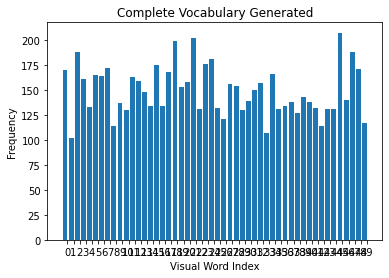

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [41]:
## loading dataset
dataset_path = "/content/dataset"
no_clusters = 50
bovw = BOVW(dataset_path)
#calling functions of class to perform BOVW implementation
image_paths, image_classes, class_id, training_names = bovw.get_img_paths_classes(mode='Train')
descriptors_float, des_list = bovw.get_features_descriptors(image_paths, image_classes, class_id)
im_features, stdSlr, k, voc=bovw.get_final_features(descriptors_float, des_list, image_paths)
bovw.plotHistogram(im_features, no_clusters )
bovw.train_and_save_model(im_features, image_classes, training_names, stdSlr, k, voc)

### Loading test data and testing

In [25]:
# Load the classifier, class names, scaler, number of clusters and vocabulary 
#from stored pickle file (generated during training)
clf, classes_names, stdSlr, k, voc = joblib.load("bovw.pkl")

['0001', '00010', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009']
true_class =['00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '00001', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '000010', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00002', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00003', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00004', '00

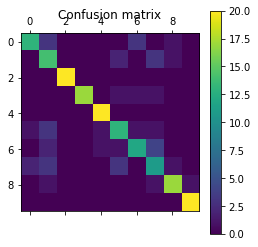

[13 14 20 17 20 13 12 11 17 20] [ 3 12  0  0  2  7  5 10  3  1] [177 168 180 180 178 173 175 170 177 179] [7 6 0 3 0 7 8 9 3 0]
true positive rate:  [0.65 0.7  1.   0.85 1.   0.65 0.6  0.55 0.85 1.  ] false positive rate:  [0.01666667 0.06666667 0.         0.         0.01111111 0.03888889
 0.02777778 0.05555556 0.01666667 0.00555556]
Accuracy:  [0.95  0.91  1.    0.985 0.99  0.93  0.935 0.905 0.97  0.995]
Precision: 0.5384615384615384 Recall: 0.7
F1 Score: 0.608695652173913


In [26]:
image_paths, image_classes, class_id, training_names = bovw.get_img_paths_classes(mode='Test')
descriptors_float, des_list = bovw.get_features_descriptors(image_paths, image_classes, class_id)
test_features=bovw.get_features_test(descriptors_float, des_list, image_paths)
true_class, predictions=bovw.evaluate_model(clf, test_features, image_classes, classes_names)

### Visualizing predictions

['/content/dataset/Test/0001/00029_00001.ppm', '/content/dataset/Test/0001/00079_00001.ppm', '/content/dataset/Test/0001/00143_00000.ppm', '/content/dataset/Test/0001/00079_00000.ppm', '/content/dataset/Test/0001/00455_00002.ppm', '/content/dataset/Test/0001/00455_00001.ppm', '/content/dataset/Test/0001/00468_00001.ppm', '/content/dataset/Test/0001/00143_00002.ppm', '/content/dataset/Test/0001/00025_00002.ppm', '/content/dataset/Test/0001/00143_00001.ppm', '/content/dataset/Test/0001/00455_00000.ppm', '/content/dataset/Test/0001/00136_00001.ppm', '/content/dataset/Test/0001/00136_00000.ppm', '/content/dataset/Test/0001/00029_00002.ppm', '/content/dataset/Test/0001/00029_00000.ppm', '/content/dataset/Test/0001/00079_00002.ppm', '/content/dataset/Test/0001/00025_00000.ppm', '/content/dataset/Test/0001/00136_00002.ppm', '/content/dataset/Test/0001/00025_00001.ppm', '/content/dataset/Test/0001/00468_00000.ppm', '/content/dataset/Test/00010/00464_00000.ppm', '/content/dataset/Test/00010/004

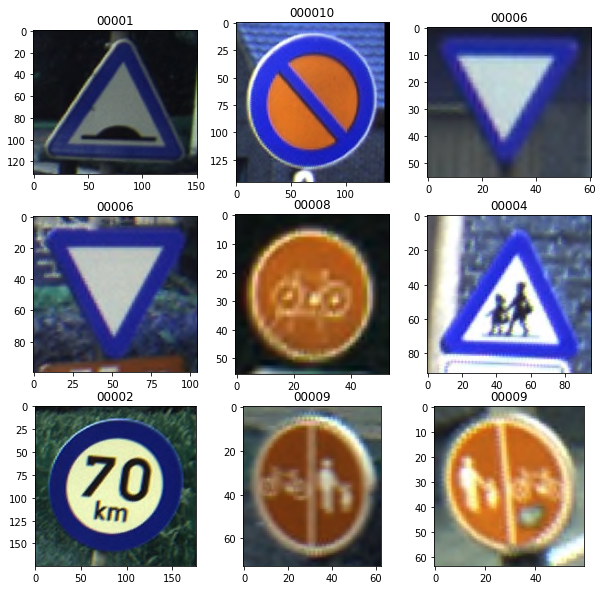

In [27]:
print(image_paths, image_classes, class_id, training_names)
#print(type(true_class))
correct_preds = np.array(true_class) == np.array(predictions)
#print(type(test_data.y))
#print(sum(correct_preds), correct_preds[:10])
### Showing correct predictions
print("Showing correct predictions...")
correct_inds, incorrect_inds = [],[]
for i,x in enumerate(correct_preds):
  if x:
    correct_inds.append(i)
  else:
    incorrect_inds.append(i)
#print(correct_inds, incorrect_inds)
correct_inds = set(np.random.choice(correct_inds, size=9))
incorrect_inds = set(np.random.choice(incorrect_inds, size=9))
#print(correct_inds, incorrect_inds)
#print(correct_inds)

print("Plotting correct predictions...")
imgs, labels = [], []
for i,x in enumerate(correct_inds):
  imgs.append(cv2.imread(image_paths[x]))
  labels.append(predictions[x])
_, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    print(img)
    ax.imshow(img)
    ax.set_title(l)
plt.show()



Plotting wrong predictions...
[[[ 50  53  64]
  [ 51  54  66]
  [ 50  53  66]
  ...
  [ 56  70 113]
  [ 56  70 113]
  [ 50  64 107]]

 [[ 56  58  65]
  [ 56  58  67]
  [ 55  57  67]
  ...
  [ 57  71 113]
  [ 57  71 114]
  [ 53  67 110]]

 [[ 55  55  60]
  [ 54  55  61]
  [ 54  55  62]
  ...
  [ 60  74 115]
  [ 58  73 115]
  [ 53  68 110]]

 ...

 [[ 53  61  70]
  [ 60  69  77]
  [ 70  81  87]
  ...
  [ 34  47  49]
  [ 35  48  50]
  [ 36  48  50]]

 [[ 58  66  75]
  [ 64  74  82]
  [ 70  82  88]
  ...
  [ 34  47  49]
  [ 36  48  50]
  [ 35  48  50]]

 [[ 57  65  74]
  [ 63  73  81]
  [ 71  82  89]
  ...
  [ 34  46  49]
  [ 35  47  49]
  [ 35  46  49]]]
[[[58 67 88]
  [58 66 88]
  [60 67 89]
  ...
  [58 68 95]
  [58 68 94]
  [59 69 93]]

 [[59 69 89]
  [59 68 88]
  [60 69 89]
  ...
  [58 68 95]
  [59 70 96]
  [61 71 96]]

 [[62 72 92]
  [62 71 91]
  [63 72 93]
  ...
  [58 69 96]
  [59 70 96]
  [60 70 95]]

 ...

 [[56 60 61]
  [57 60 62]
  [60 65 61]
  ...
  [55 61 89]
  [53 59 87]
  [50

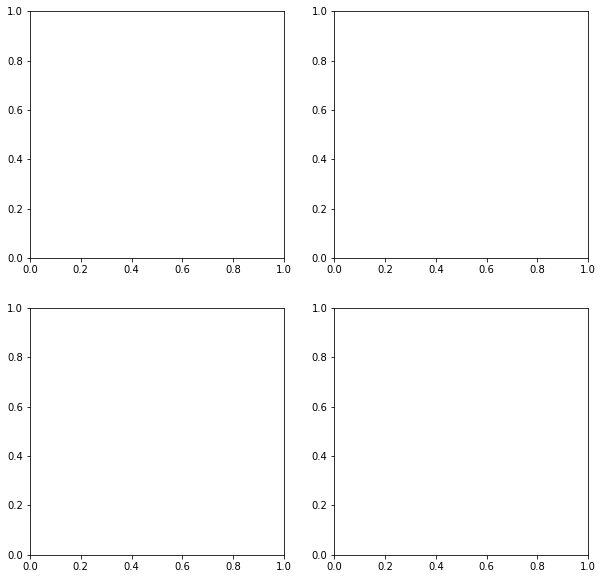

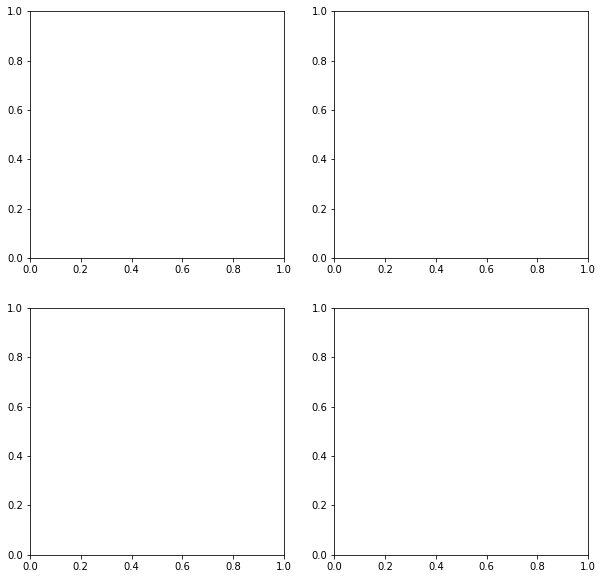

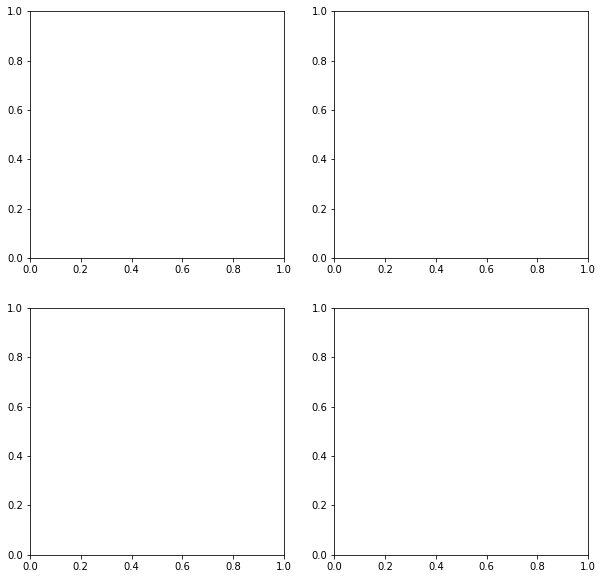

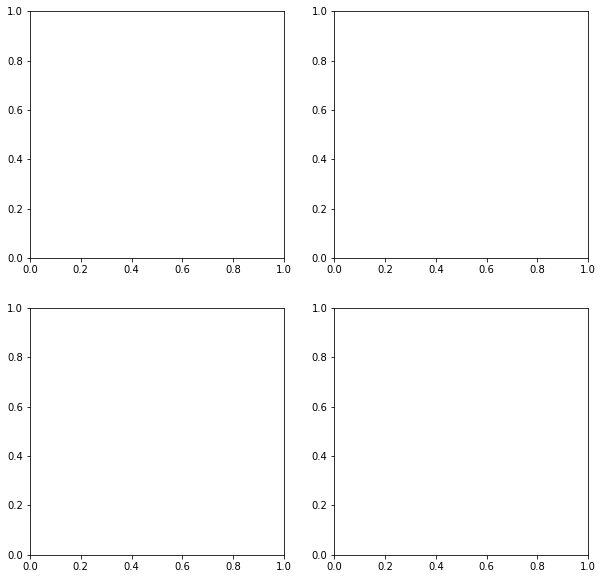

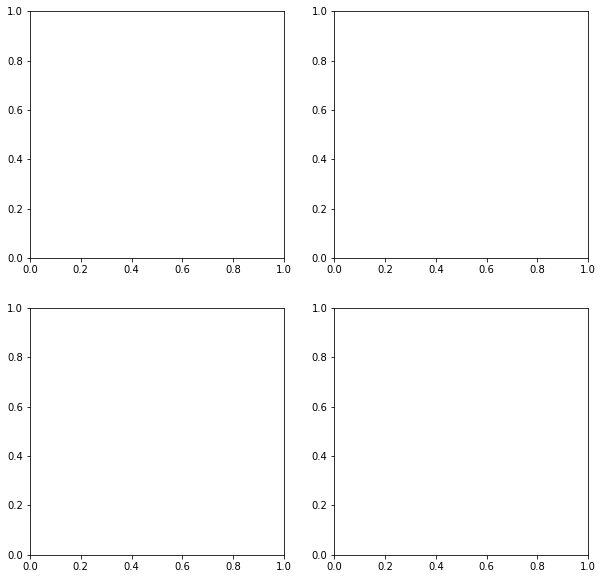

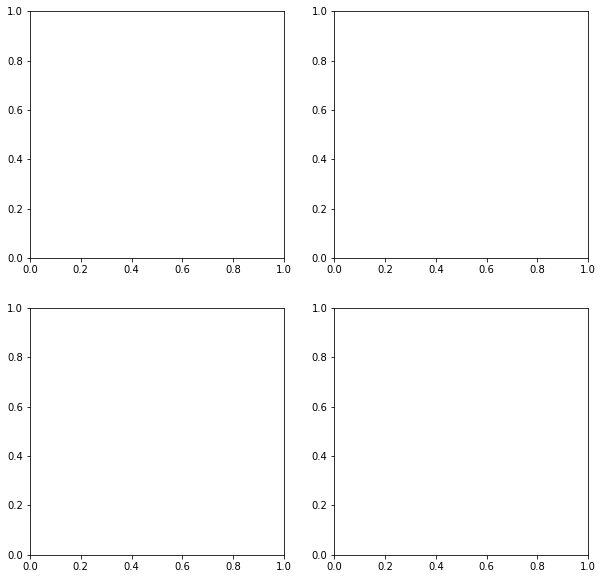

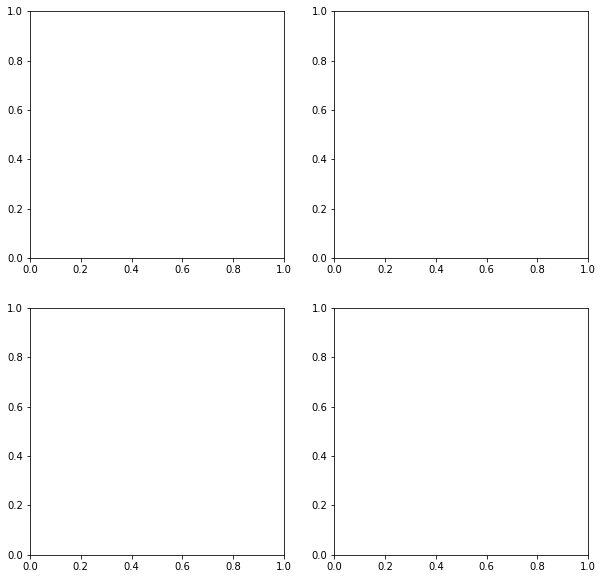

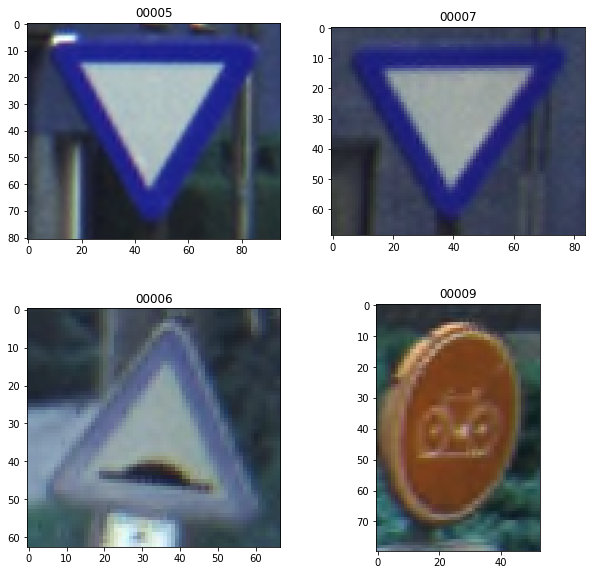

In [29]:
#this module will print wrong predictions
print("Plotting wrong predictions...")
imgs, labels = [], []
for i,x in enumerate(incorrect_inds):
 imgs.append(cv2.imread(image_paths[x]))
 labels.append(predictions[x])
 _, axs = plt.subplots(2, 2, figsize=(10, 10))
 axs = axs.flatten()
for img, ax, l in zip(imgs, axs, labels):
    print(img)
    ax.imshow(img)
    ax.set_title(l)
plt.show()